**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Trabajo Práctico:** 2

**Datos de la entrega:** Jueves 17 de octubre 2024, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo comprimido con todos los archivos de su solución a este Trabajo Práctico. En caso de requerir mucho espacio, solicitarle al profesor una carpeta en One-Drive para subir la solución.

---

**Estudiantes:**
- Andrey Arguedas Espinoza - 2020426569

# Entregable 1.  Experimentación en Image Colorization

1. El objetivo central es investigar y experimentar en el uso de Deep Learning para la tarea de Image Colorization. En particular pasar de imágenes en escala de grises a imágenes a color.
1. Como dataset puede utilizar ImageWoof (https://docs.ultralytics.com/es/datasets/classify/imagewoof/#dataset-variants)  u otro de su elección. Sobre todo considerando la capacidad de procesamiento de que disponga.
1. Puede usar una biblioteca como OpenCV para obtener las imágenes en escala de grises, o incluso pasar las imágenes iniciales de RGB al espacio de color CIE LAB (el canal L le servirá).
1. Usted debe proponer e implementar el Diseño Experimental, el cual debe considerar al menos tres arquitecturas: dos existentes y una tercer arquitectura propuesta por Usted, no es problema que sea alguna de las dos primeras con algún cambio propuesto por Usted. Es requisito que se programen las capas requeridas para la red neuronal artificial, no usar frameworks que con la llamada a una función retornen el resultado.
1. Es válido utilizar código de alguna fuente como base, pero debe ser citada claramente la fuente.

## • Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner as kt
import seaborn as sns
import cv2
import tensorflow_io as tfio
import onnxruntime as ort
from collections import defaultdict
from skimage import color
from PIL import Image
from tensorflow import keras
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization


### • Define global size for all our images, we will use this dimensions across our project, it also helps to reduce the resources needed to run the project and unifies the size of all images since in this dataset the images size is not unified

### • Define global variables for the project

In [2]:
images_dimensions = (120, 120)
reshapable_dimension = (120, 120, 1)
local_batch_size = 64
images_to_predict = 10
#Checkpoints folder for the basic encoder-decoder model
checkpoints_encoder_decoder_path = 'checkpoints_encoder_decoder'
#Checkpoints folder for the U-Net model
checkpoints_unet_path = 'checkpoints_unet'
#Checkpoints folder for the DE2COLAB model
checkpoints_de2c0AB_path = 'checkpoints_de2coLAB'
#checkpoint filename to save
checkpoint_filename = 'colorization_model{epoch:02d}.h5'
#checkpoint filename to load
checkpoint_filename_load = 'colorization_model80.h5'
train_epochs_amount = 80

## • Load the Dataset, for this project we use the imagewoof2-160 which is an smaller version of the image-woof dataset, we also apply the resize to 120*120 px while loading

In [3]:
print("Loading train dataset in progess....")

# Load the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './imagewoof2-160/train',
    batch_size=local_batch_size,  # Batch size
    image_size=images_dimensions,  # Resize images to the required input size for your model
)

print("Loading train dataset completed!!!")


Loading train dataset in progess....
Found 9025 files belonging to 10 classes.
Loading train dataset completed!!!


## • Visualize a few images from training to see they are loading correctly

In [4]:
def visualize_images_lot(images, labels, lot_size = 16, rows = 4, cols= 4, figsize=(20, 20)):
    plt.figure(figsize=figsize)
    for i in range(lot_size): 
        ax = plt.subplot(rows, cols, i + 1)  # Create a rowsxcols grid for displaying images
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to numpy and display
        plt.title(f"Label: {labels[i].numpy()}")  # Show the label    
    plt.show()  # Display the images

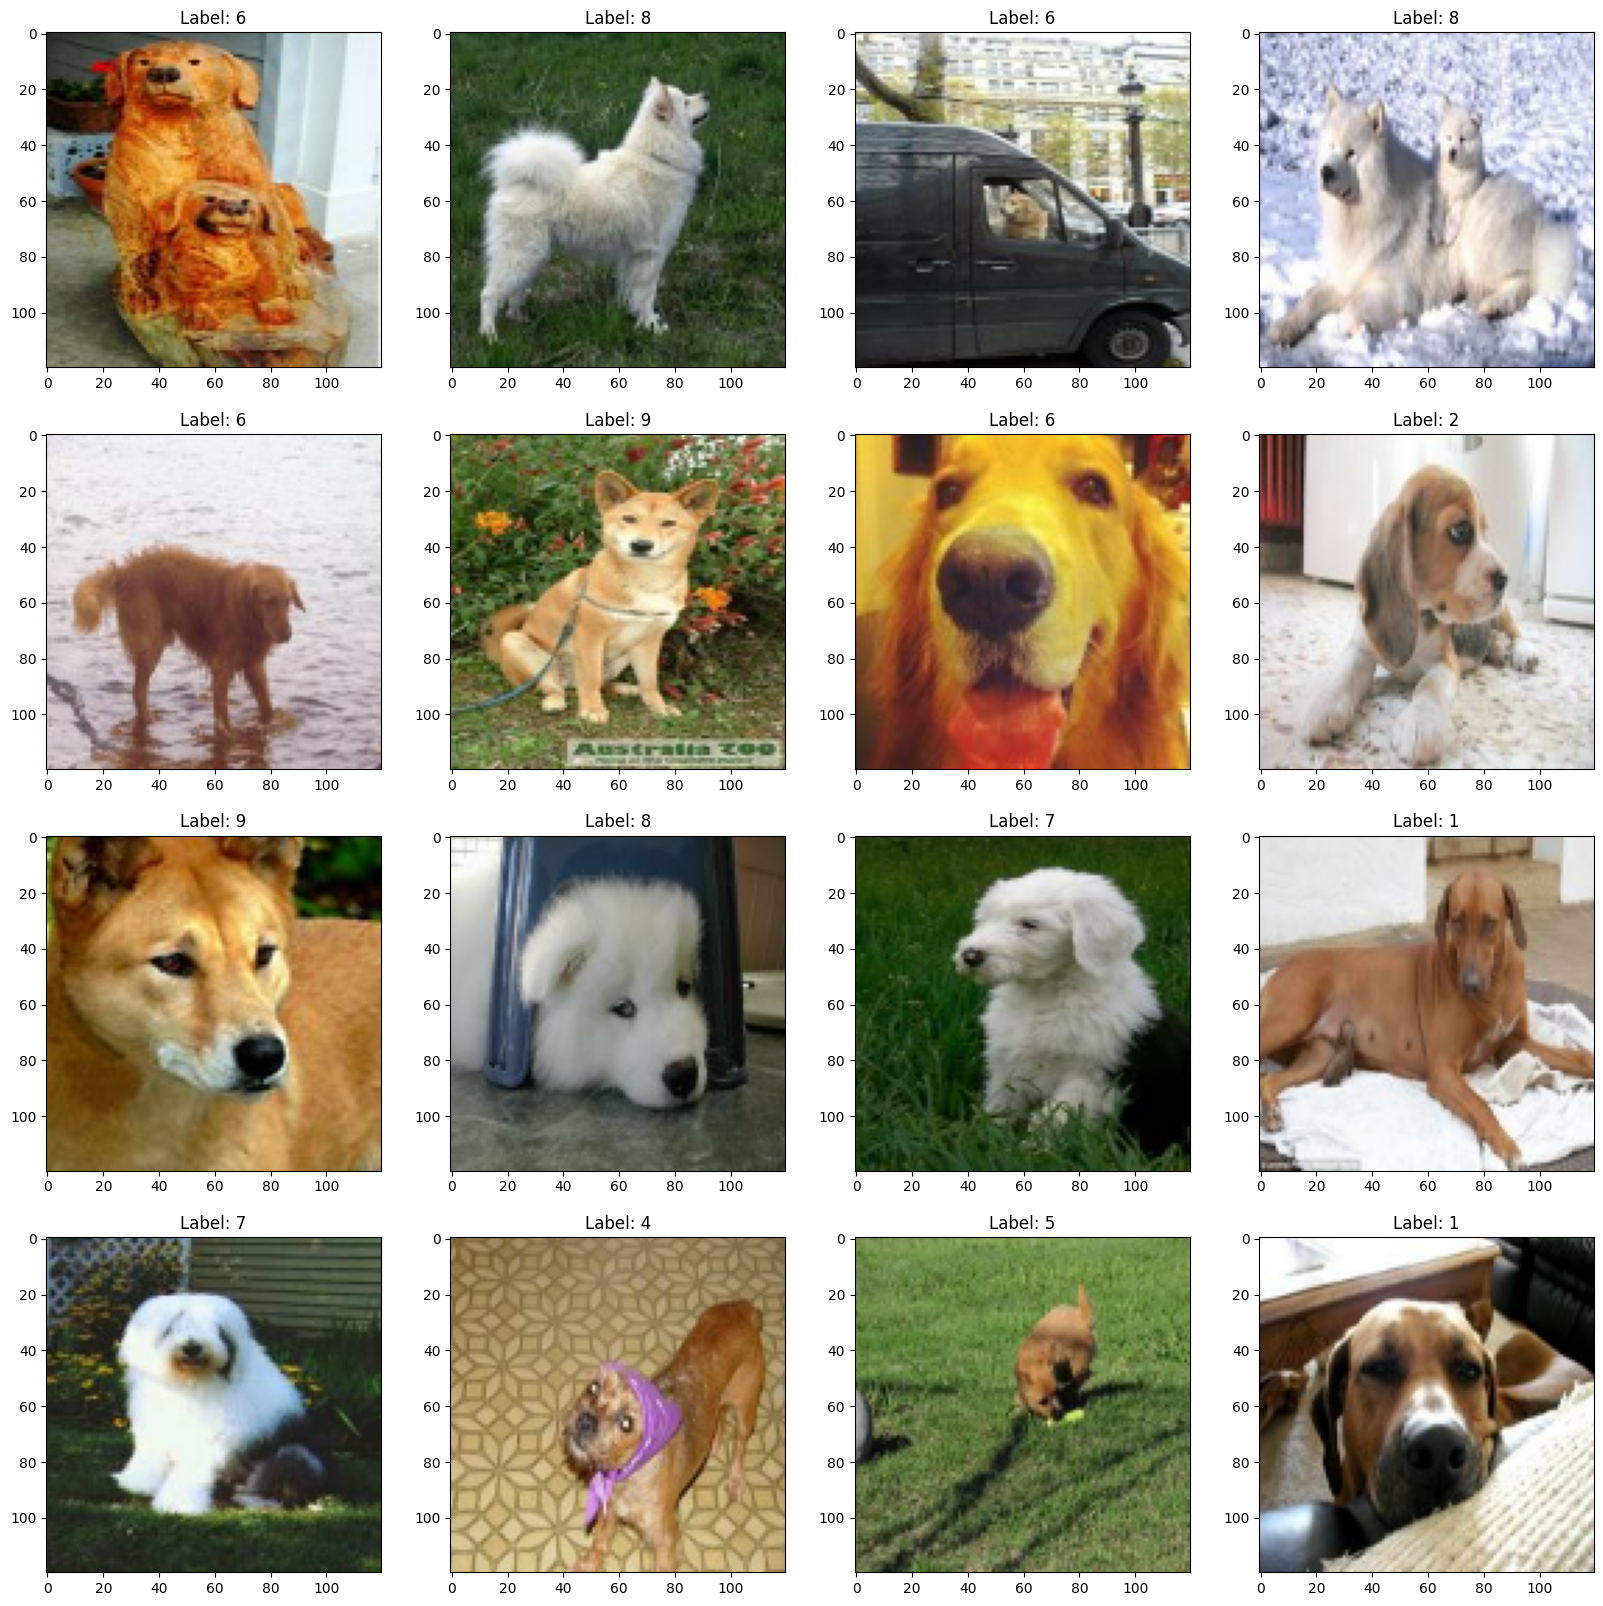

In [5]:
for first_images, first_labels in train_dataset.take(1):
    break
    
visualize_images_lot(first_images, first_labels)

## • Now we will convert our training dataset to the CIELAB color space

In [6]:
# Convert RGB image to Lab color space
def rgb_to_lab(image, label):
    normalized_image = image / 255.0
    lab_img = tfio.experimental.color.rgb_to_lab(normalized_image)
    return lab_img, label

In [7]:
# Convert LAB to RGB
def lab_to_rgb(lab_img):
    rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)
    return rgb_img

In [8]:
train_dataset_lab = train_dataset.map(rgb_to_lab)

## • Now we can plot a few images of our training dataset to the CIELAB color space to see how each channel looks

In [9]:
def visualize_images_lot_LAB(images, lot_size = 5, figsize=(10, 10)):
    for i in range(lot_size):
        fig, axs = plt.subplots(1, 3, figsize=(10, 10))
        image_lab = images[i]
    
        axs[0].imshow(image_lab[:, :, 0], cmap='gray')
        axs[0].set_title('L* (Lightness)')

        axs[1].imshow(image_lab[:, :, 1], cmap='RdYlGn')
        axs[1].set_title('a* (Red-Green)')

        axs[2].imshow(image_lab[:, :, 2], cmap='YlGnBu')
        axs[2].set_title('b* (Yellow-Blue)')
    
    plt.show()

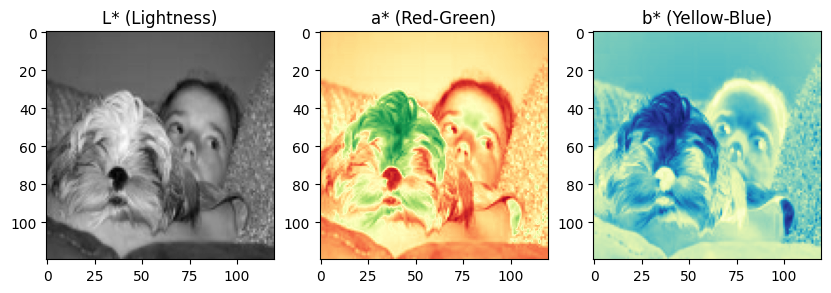

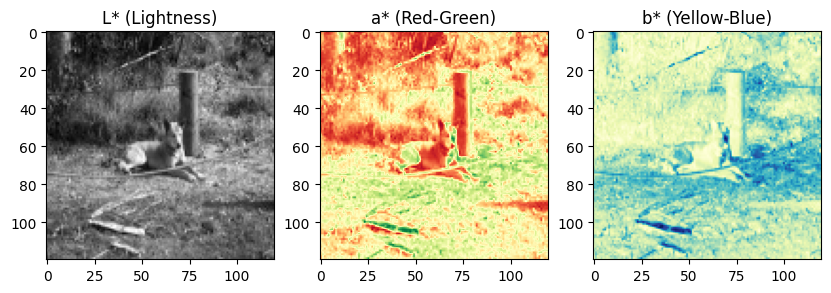

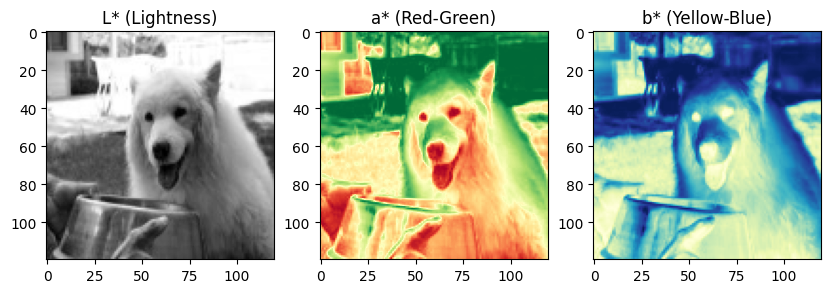

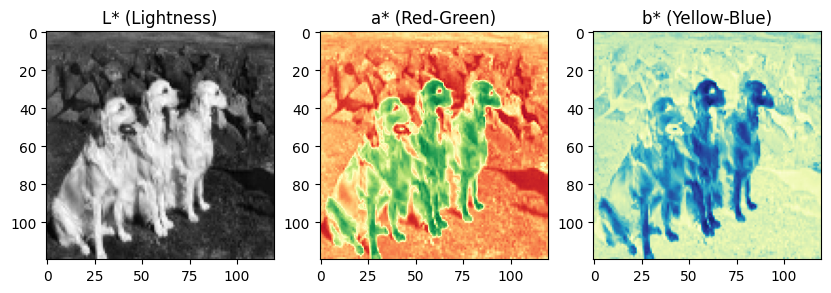

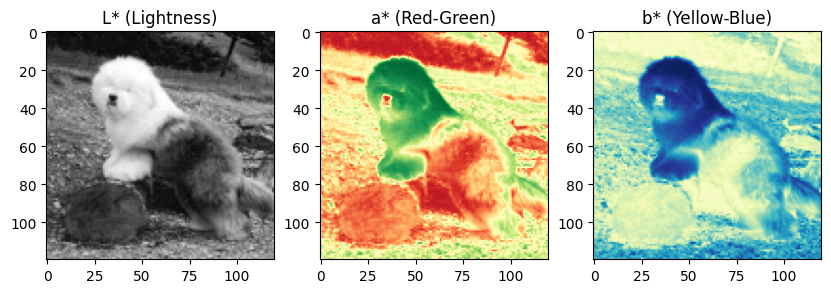

In [10]:
# Take the first batch from the dataset already converted to CIELAB
for images, labels in train_dataset.take(1):
    break  # You only need one batch

visualize_images_lot_LAB(images, 5)

### • In order to have a better handle of the dataset we first unbatch it and handle it as numpy array
### Note this could take a few seconds since there are too many images

In [11]:
train_dataset_lab = train_dataset_lab.unbatch()
train_dataset_lab_images = np.asarray(list(train_dataset_lab.map(lambda x, y: x)))

print("Shape of train images in LAB format", train_dataset_lab_images.shape)

Shape of train images in LAB format (9025, 120, 120, 3)


## • Data normalization

### • First we normalize the CIE-LAB images. Note that the grayscale channel (L) normalizes different than the AB channels

In [12]:
#Images only with grayscale channel
X_grayscale_images_lab = train_dataset_lab_images[:, :, :, 0] / 255.0

#Images with AB channels
y_AB_channels_lab = train_dataset_lab_images[:, :, :, 1:] / 128.0

## • Show the normalized image to see they are still visible on the LAB channels but in a normalized way. It is expected to see more pixelated AB channels

In [13]:
def visualize_images_lot_LAB_Channels(L_channel, AB_channels, lot_size = 5, figsize=(10, 10)):
    for i in range(lot_size):
        fig, axs = plt.subplots(1, 3, figsize=figsize)
        l_channel = L_channel[i]
        ab_channels = AB_channels[i]
    
        axs[0].imshow(l_channel, cmap='gray')
        axs[0].set_title('L* (Lightness)')

        axs[1].imshow(ab_channels[:, :, 0], cmap='RdYlGn')
        axs[1].set_title('a* (Red-Green)')

        axs[2].imshow(ab_channels[:, :, 1], cmap='YlGnBu')
        axs[2].set_title('b* (Yellow-Blue)')
    
    plt.show()

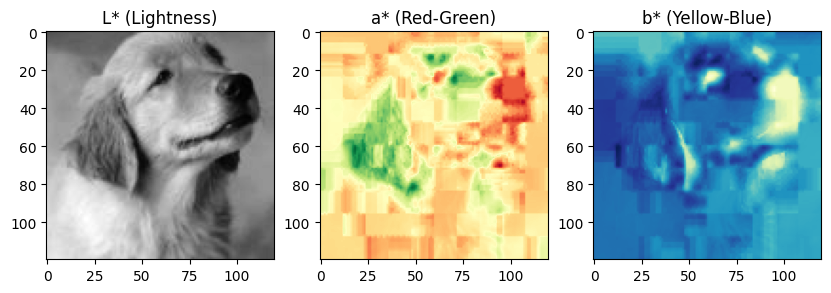

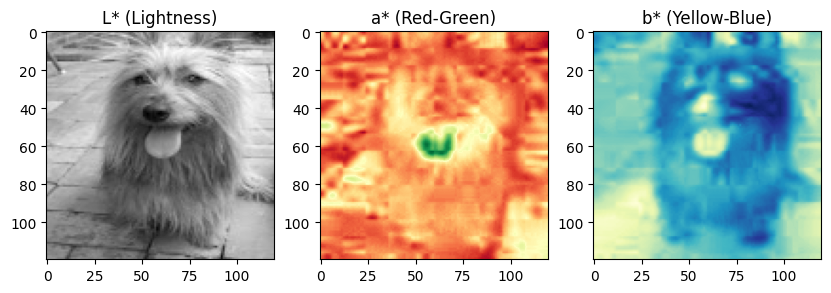

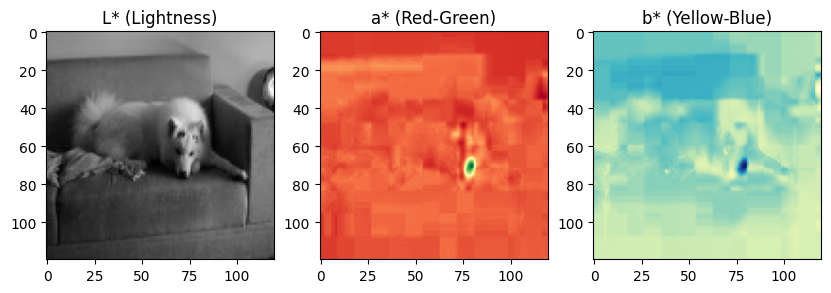

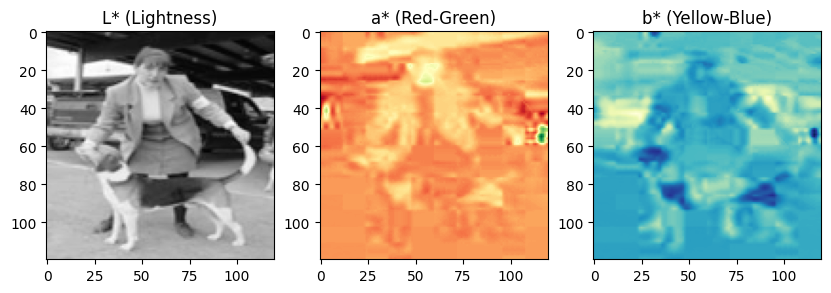

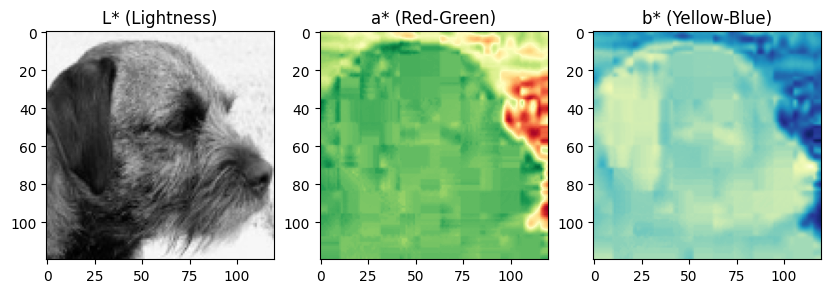

In [14]:
visualize_images_lot_LAB_Channels(X_grayscale_images_lab, y_AB_channels_lab, 5)

## Architecures 

## • Architecure # 1 Encoder - Decoder :
### • We implement a Encoder -  Decoder version, the encoder treats the grayscale image while the decoder works trying to predict the AB channels.
### • The tanh activation function at the end will help us to obtain values negatives and positives making possible to predict the AB channels.

In [15]:
def create_encoder_decoder_colorization_model(input_shape=reshapable_dimension):
    model = models.Sequential()

     # Encoder
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Bottleneck
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    # Decoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))  # Output 2 channels (AB)
    return model

### • Load the encoder-decoder model if esxists, if not create a new one.
### • Show a summary of the Encoder-Decoder architecture

In [16]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_encoder_decoded_loaded_from_disk = False

if os.path.isfile(checkpoints_encoder_decoder_path + '/'  + checkpoint_filename_load):
    print("Loading saved encoder-decoder model!!!")
    encoder_decoder_model = tf.keras.models.load_model(checkpoints_encoder_decoder_path + '/'  + checkpoint_filename_load)
    was_encoder_decoded_loaded_from_disk = True
else:
    print("Creating encoder-decoder model!!!")
    encoder_decoder_model = create_encoder_decoder_colorization_model(reshapable_dimension)
    
encoder_decoder_model.summary()

Loading saved encoder-decoder model!!!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 120, 120, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                 

## • Architecture # 2 U-Net.
### This model is more complex than the previous one, however it performs better, this is a reduced version of the original one, since the original one consumes too many resources for the hardware we currently have.

### It also has tanh as the final activation function

In [17]:
def create_unet_colorization_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Contracting Path (Downsampling) with fewer filters and layers
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    b = layers.BatchNormalization()(b)
    
    # Expanding Path (Upsampling) with fewer filters
    u3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u3 = layers.concatenate([u3, c3])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c4 = layers.BatchNormalization()(c4)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.BatchNormalization()(c5)

    u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u1 = layers.concatenate([u1, c1])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c6 = layers.BatchNormalization()(c6)
    
    # Output Layer (Predict a, b channels)
    outputs = layers.Conv2D(2, (1, 1), activation='tanh')(c6)
    
    # Define the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

### Load the U-net model if exists, if not create a new one.
### Show a summary of the U-net architecture

In [18]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_UNet_loaded_from_disk = False

if os.path.isfile(checkpoints_unet_path + '/'  + checkpoint_filename_load):
    print("Loading saved U-Net model!!!")
    UNet_model = tf.keras.models.load_model(checkpoints_unet_path + '/'  + checkpoint_filename_load)
    was_UNet_loaded_from_disk = True
else:
    print("Creating U-Net model!!!")
    UNet_model = create_unet_colorization_model(reshapable_dimension)
    
UNet_model.summary()

Loading saved U-Net model!!!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 120, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 120, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                

## • Architecture # 3 DE2CO-LAB.
### Here we propose a model that implements the DE2CO in order to predict LAB images with a depth map

In [19]:
# Residual block definition
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    # Single convolutional layer in this smaller version
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Adjust the shortcut connection in case the input and output dimensions differ
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Add the shortcut connection to the output
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

# Smaller Encoder-Decoder model with skip connections
def create_DE2CO_model(input_shape=reshapable_dimension, final_activation='tanh', output_amount=2):
    inputs = layers.Input(shape=input_shape)

    # Smaller Encoder: Fewer residual blocks and filters
    x = residual_block(inputs, 8)   # Reduced filters
    x = residual_block(x, 16)
    encoded = residual_block(x, 32)

    # Smaller Decoder: Fewer layers and filters
    x = layers.Conv2DTranspose(16, kernel_size=3, strides=1, padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(8, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Final upsampling layer to output 3-channel RGB image
    outputs = layers.Conv2D(output_amount, kernel_size=3, strides=1, padding='same', activation=final_activation)(x)

    # Define the model
    model = models.Model(inputs, outputs)

    return model

### This model needs to generate the DEPTH images of the train inputs before starting the training

In [20]:
# Load the ONNX model for MiDaS
onnx_model_path = "midas_v21_small_256.onnx"  # Make sure you have the ONNX model file
ort_session = ort.InferenceSession(onnx_model_path)

# Preprocess the input image
def preprocess_image(img):
    img = cv2.resize(img, (256, 256))  # Resize to input size required by MiDaS model
    img = img.astype(np.float32) / 255.0  # Normalize the RGB image
    img = np.transpose(img, (2, 0, 1))  # Change to (channels, height, width)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Run depth estimation using ONNX model
def estimate_depth(img):
    input_image = preprocess_image(img)
    input_name = ort_session.get_inputs()[0].name
    depth_map = ort_session.run(None, {input_name: input_image})[0]
    
    # Postprocess depth map (for visualization)
    depth_map = depth_map.squeeze()

    # Resize the depth map to our required dimensions
    depth_map = cv2.resize(depth_map, images_dimensions, interpolation=cv2.INTER_LINEAR)
    
    depth_map = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))  # Normalize depth map
    return depth_map

### Here we show an example of how this depth map looks

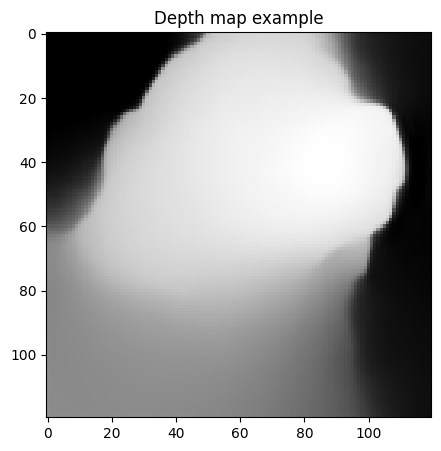

In [21]:
# Example usage
original_rgb = lab_to_rgb(train_dataset_lab_images[0])

depth_map = estimate_depth(original_rgb * 255.0)

plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)  # Create a rowsxcols grid for displaying images
plt.imshow(depth_map, cmap='gray')  # Convert tensor to numpy and display
plt.title("Depth map example")  # Show the label    
plt.show()  # Display the images

In [22]:
def estimated_depths(data_images):
    # Loop over the dataset and apply the function to each image
    estimated_depths_array = np.zeros((data_images.shape[0], 120, 120, 1))
    for i in range(data_images.shape[0]):
        estimated_depths_array[i] = estimate_depth(data_images[i]).reshape(120, 120, 1)
        if i % 1000 == 0:
            print("Loading ", i)
    print("Finished!!!")
    return estimated_depths_array

### Load the DE2CO model if esxists, if not create a new one.
### Show a summary of the DE2CO architecture 

In [23]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_DE2COAB_loaded_from_disk = False

if os.path.isfile(checkpoints_de2c0AB_path + '/'  + checkpoint_filename_load):
    print("Loading saved DE2CO-LAB model!!!")
    de2coAB_model = tf.keras.models.load_model(checkpoints_de2c0AB_path + '/'  + checkpoint_filename_load)
    was_DE2COAB_loaded_from_disk = True
else:
    print("Creating DE2CO-LAB model!!!")
    de2coAB_model = create_DE2CO_model(reshapable_dimension, 'tanh', 2)
    
de2coAB_model.summary()

Creating DE2CO-LAB model!!!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 120, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 120, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                  

## *********************** Training phase *************************

### We use this common function to train all the architectures of our project, it also creates the checkpoints that we will save for each architecture

In [24]:
# Training the model
def train_model(model, X_train, y_train, batch_size=64, epochs=50, validation_split=0.2, checkpoint_dir=''):
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', 'Precision'])

    # Create checkpoints folder
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, checkpoint_filename),
        save_weights_only=False,  # Save the entire model, not just weights
        save_best_only=False,     # Save the model after every epoch, not just the best one
        monitor='val_loss',
        mode='min'
    )
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[checkpoint_cb])
    return history

In [25]:
def visualize_metrics(history, under_lim = -2, upper_lim = 2):
    pd.DataFrame(history.history).plot(figsize=(10, 7))
    plt.grid(True)
    plt.gca().set_ylim(under_lim, upper_lim)
    plt.xlabel("epochs")
    plt.show()

### Here we train the models if we do not find a saved model for them...

### • Train Architecture #1 Encoder-Decoder

In [26]:
if was_encoder_decoded_loaded_from_disk is False:
    history = train_model(encoder_decoder_model, X_grayscale_images_lab, y_AB_channels_lab, batch_size=local_batch_size, epochs=train_epochs_amount, checkpoint_dir=checkpoints_encoder_decoder_path)
    visualize_metrics(history)

### • Train Architecture #2 U-NET

In [27]:
if was_UNet_loaded_from_disk is False:
    history = train_model(UNet_model, X_grayscale_images_lab, y_AB_channels_lab, batch_size=local_batch_size, epochs=train_epochs_amount , checkpoint_dir=checkpoints_unet_path)
    visualize_metrics(history)

### Train Architecture #3 - DE2CO-AB
### Note that before start training it needs to generate the Depth Images using Midas, this will take a while

In [28]:
train_rgb_images = []
train_depth_estimations = []
original_rgb_train = np.zeros((train_dataset_lab_images.shape[0], train_dataset_lab_images.shape[1], train_dataset_lab_images.shape[2], train_dataset_lab_images.shape[3]))
if was_DE2COAB_loaded_from_disk is False:    
    for i in range(original_rgb_train.shape[0]):
        original_rgb_train[i] = lab_to_rgb(train_dataset_lab_images[i]) * 255.0 
    train_depth_estimations = estimated_depths(original_rgb_train)

Loading  0
Loading  1000
Loading  2000
Loading  3000
Loading  4000
Loading  5000
Loading  6000
Loading  7000
Loading  8000
Loading  9000
Finished!!!


In [ ]:
if was_DE2COAB_loaded_from_disk is False:
    history = train_model(de2coAB_model, train_depth_estimations, y_AB_channels_lab, batch_size=local_batch_size, epochs=train_epochs_amount, checkpoint_dir=checkpoints_de2c0AB_path)
    visualize_metrics(history)

Epoch 1/80
113/113 [==============================] - 114s 999ms/step - loss: 0.0524 - accuracy: 0.7067 - precision: 0.9994 - val_loss: 0.0122 - val_accuracy: 0.7699 - val_precision: 0.0000e+00
Epoch 2/80
113/113 [==============================] - 115s 1s/step - loss: 0.0118 - accuracy: 0.7660 - precision: 0.9996 - val_loss: 0.0107 - val_accuracy: 0.7878 - val_precision: 0.0000e+00
Epoch 3/80
113/113 [==============================] - 113s 998ms/step - loss: 0.0107 - accuracy: 0.7701 - precision: 0.9996 - val_loss: 0.0117 - val_accuracy: 0.7864 - val_precision: 1.0000
Epoch 4/80
113/113 [==============================] - 95s 837ms/step - loss: 0.0104 - accuracy: 0.7728 - precision: 0.9992 - val_loss: 0.0155 - val_accuracy: 0.7859 - val_precision: 1.0000
Epoch 5/80
113/113 [==============================] - 95s 838ms/step - loss: 0.0103 - accuracy: 0.7742 - precision: 0.9971 - val_loss: 0.0135 - val_accuracy: 0.7878 - val_precision: 1.0000
Epoch 6/80
113/113 [===========================

## ************************************* Test phase ********************************************

### Here we will compare all the architectures

In [ ]:
print("Loading test dataset in progess....")

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './imagewoof2-160/val',
    batch_size=local_batch_size,  # Batch size
    image_size=images_dimensions,  # Resize images to the required input size for your model
)

print("Loading test dataset completed!!!")

### • We start by mapping the the test data to LAB format since we will need to generate grayscale of these images and then replace its AB channels with the predicted ones

In [ ]:
test_dataset = test_dataset.map(rgb_to_lab)

In [ ]:
test_dataset_lab = test_dataset.unbatch()
test_dataset_lab_images = np.asarray(list(test_dataset_lab.map(lambda x, y: x)))

print("Shape of test LAB images: ", test_dataset_lab_images.shape)

### Data Normalization for the test partition

In [ ]:
#Images only with grayscale channel
test_images_grayscale = test_dataset_lab_images[:, :, :, 0] / 255.0
test_images_AB_channels = test_dataset_lab_images[:, :, :, 1:]

print("Shape of grayscale images: ", test_images_grayscale.shape)
print("Shape of AB channels: ", test_images_AB_channels.shape)

### • Now we can start predcting from grayscale channels to AB channels

In [ ]:
def predict_channels(grayscale_image, model):
    reshape_gray_image = grayscale_image.reshape(1 , grayscale_image.shape[0], grayscale_image.shape[1], 1)
    ab_channels = model.predict(reshape_gray_image)
    denormalized_ab_channels = ab_channels[0] * 128.0
    return denormalized_ab_channels

In [ ]:
def lot_predictions(grayscale_images, model, lot_size = 5):
    predictions_lot = []
    for i in range(lot_size):
        predictions_lot.append(predict_channels(grayscale_images[i], model))
    return predictions_lot

### We predict a few of the first images of our test data, to se how is predicting
### The DE2CO model takes a little bit more of time since it needs to generate the Depth Gray images of the images to predict

In [ ]:
print("Predict using the encoder-decoder model")
encoder_decoder_predictions = lot_predictions(test_images_grayscale, encoder_decoder_model, images_to_predict)
print("Predict using the UNet model")
UNet_predictions = lot_predictions(test_images_grayscale, UNet_model, images_to_predict)

test_depths = []

for i in range(images_to_predict):
    test_original_rgb = lab_to_rgb(test_dataset_lab_images[i])
    estimated_depth_from_original = estimate_depth(test_original_rgb * 255.0)
    test_depths.append(estimated_depth_from_original)

print("Predict using the DE2CO-LAB model")
DE2COAB_predictions = lot_predictions(test_depths, de2coAB_model, images_to_predict)

### • Now let's plot our predictions

In [ ]:
print("Encoder - Decoder Predictions")
visualize_images_lot_LAB_Channels(test_images_grayscale, encoder_decoder_predictions, images_to_predict)
print("UNet Predictions")
visualize_images_lot_LAB_Channels(test_images_grayscale, UNet_predictions, images_to_predict)
print("DE2CO-LAB Predictions")
visualize_images_lot_LAB_Channels(test_depths, DE2COAB_predictions, images_to_predict)

### • Now let's plot what it was expected in terms of channels

In [ ]:
visualize_images_lot_LAB_Channels(test_images_grayscale, test_images_AB_channels, images_to_predict)

### • Finally we compare the original image vs the predicted one in RGB format to see the differences

In [ ]:
def compare_original_vs_predicted(original_test_image, predicted_AB_channels, lot_size = 5, figsize=(15, 15)):
    for i in range(lot_size):
        fig, axs = plt.subplots(1, 5, figsize=figsize)

        axs[0].imshow(original_test_image[i, :, :, 0], cmap='gray')
        axs[0].set_title('Grayscale Input')
        
        original_test_image_rgb = lab_to_rgb(original_test_image[i])
    
        axs[1].imshow(cv2.cvtColor(original_test_image_rgb, cv2.COLOR_BGR2RGB))
        axs[1].set_title('Ground Truth')


        original_test_image[i, :, :, 1:] = predicted_AB_channels[0][i]  # Replace AB channels in the original LAB image

        predicted_image_rgb = lab_to_rgb(original_test_image[i])
        

        axs[2].imshow(cv2.cvtColor(predicted_image_rgb, cv2.COLOR_BGR2RGB))
        axs[2].set_title('Encoder-Decoder')

        original_test_image[i, :, :, 1:] = predicted_AB_channels[1][i]  # Replace AB channels in the original LAB image

        predicted_image_rgb = lab_to_rgb(original_test_image[i])

        axs[3].imshow(cv2.cvtColor(predicted_image_rgb, cv2.COLOR_BGR2RGB))
        axs[3].set_title('U-Net')


        original_test_image[i, :, :, 1:] = predicted_AB_channels[2][i]  # Replace AB channels in the original LAB image

        predicted_image_rgb = lab_to_rgb(original_test_image[i])
        

        axs[4].imshow(cv2.cvtColor(predicted_image_rgb, cv2.COLOR_BGR2RGB))
        axs[4].set_title('DE2CO-LAB')
        
        plt.show()

In [ ]:
compare_original_vs_predicted(test_dataset_lab_images, [encoder_decoder_predictions, UNet_predictions, DE2COAB_predictions], images_to_predict)